## Prepare single-cell data for bulk deconvolution 
### SCDC and Scaden

For SCDC, prepare loom files that are read into ExpressionSet. SCDC takes ExpressionSet objects with raw read counts as input.

Currently, we are unable to convert from AnnData to Seurat, and to expressionSet in R, so we have to
convert first to loom. This is also convenient to read in the data in Phyton. However, the large matrices
cannot be handled in R (`Error: cannot allocate vector of size`), and pre-allocation doesn't solve the isssue either. So for HCA and SCP498, we need to downsample the data.

Seea also https://mojaveazure.github.io/seurat-disk/index.html or https://satijalab.org/seurat/articles/conversion_vignette.html

For Scaden, we need to split the data according to the samples for training, and also between scRNA-seq and snRNA-seq. This is likely to improve feature learning (individual, protocol batches, *etc.*).
For SCP498, each sample was also processed in replicate, but we do not take this information into account.
This is all done separately, but we don't have to downsample as all marices are text files. Raw conts are normalized separately.


### scRNA-seq and snRNA-seq

Processed scRNA-seq data GEO accession codes GSE109816 and GSE121893 (data re-analysed).

Processed scRNA- and snRNA-seq data from https://www.heartcellatlas.org

Processed snRNA-seq data from https://singlecell.broadinstitute.org/single_cell/study/SCP498/transcriptional-and-cellular-diversity-of-the-human-heart#study-download


In [385]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import loompy as lp

In [407]:
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

In [374]:
# data

scDir = '/prj/LZ_PR2B_rewiring'

# GSE109816: raw data, re-analysed
# HCA_Heart: raw data
# SCP498: raw data, use the h5ad V4, separate MTX UMI matrix and metadata are under 
# expression/5d544a83328cee364c3cfce9/gene_sorted-matrix.mtx, and metadata/meta.data.v3.txt
dirs = {
    'GSE109816': os.path.join(scDir, 'notebooks', 'GSE109816', 'results'),
    'HCA_Heart': os.path.join(scDir, 'public', 'HCA_Heart'),
    'SCP498': os.path.join(scDir, 'public', 'SCP498', 'other')
}
dataf = {
    'GSE109816': 'heart-clustering.h5ad',
    'HCA_Heart': 'global_raw.h5ad',
    'SCP498': 'healthy_human_4chamber_map_unnormalized_V4.h5ad'
}

outputDir = '/prj/MAGE/analysis/deconvolution/scdata'


In [ ]:
# start by sorting gene ids for all 3 datasets
#########################################################################################################

scData = 'GSE109816'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)
adata.var.index.name = None
ll = []
ll.append(adata.var)
scData = 'HCA_Heart'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)
adata.var.index.name = None
ll.append(adata.var)
ll[1] = pd.DataFrame(ll[1]['gene_ids-Sanger-Cells']) # HCA
ll[1].rename(columns={'gene_ids-Sanger-Cells': 'gene_ids'}, inplace=True)
scData = 'SCP498'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)
adata.var.index.name = None
ll.append(adata.var)


genes = list(ll[0].index.values)
genes.extend(list(ll[1].index.values))
genes.extend(list(ll[2].index.values))
genes = list(set(genes))
with open("/prj/LZ_PR2B_rewiring/public/joint_names.txt", "w") as outfile:
    outfile.write("\n".join(genes))
    
# R
# library(EnsDb.Hsapiens.v86) 
# genenames = read.table('/prj/LZ_PR2B_rewiring/public/joint_names.txt', check.names=FALSE)
# m <- mapIds(EnsDb.Hsapiens.v86,
#             keys=as.character(genenames$V1),
#             column="GENEID",
#             keytype="SYMBOL",
#             multiVals="first")
# m <- t(data.frame(as.list(m), check.names=FALSE))
# write.table(m,'/prj/LZ_PR2B_rewiring/public/EnsDb.Hsapiens.v86.csv', 
#             row.names=T, col.names=F,
#             quote=F, sep=",")

df = pd.merge(ll[1], ll[2], left_index=True, right_index=True, how='outer')
# none are actually NaN on both!
df.gene_ids.fillna(df.ids, inplace=True)
df.ids.fillna(df.gene_ids, inplace=True)

# df[df.gene_ids!=df.ids] 313 rows! use gene_ids 

genes = pd.read_csv('/prj/LZ_PR2B_rewiring/public/EnsDb.Hsapiens.v86.csv', 
                    header=None, names=['gene_ids_'], index_col=0)
genes = pd.merge(df, genes, left_index=True, right_index=True, how='outer')
# any NaN in gene_ids or ids arise from missing entries
genes.gene_ids.fillna(genes.gene_ids_, inplace=True)
# fill remaining with symbol 
genes.loc[genes.gene_ids.isna(), 'gene_ids'] = genes[genes.gene_ids.isna()].index.values
genes = genes[['gene_ids']]

del ll

In [360]:
# standardize the nomenclature
#########################################################################################################

anndl = {}
anndl_scdc = {}

scData = 'GSE109816'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)

adata.obs.index.name = None
adata.var.index.name = None

# add gene ids
adata.var = adata.var.merge(genes, left_index=True, right_index=True, how='left')

# clean the data to keep only minimal metadata
# rename variables, and cell types
to_keep = ['Age', 'Gender', 'Individual', 'Type', 'condition', 'n_counts', 'n_genes',
           'study', 'leiden0.12', 'sub_clust', 'tissue_src']
adata.obs = adata.obs[to_keep]
adata.obs = adata.obs.rename(columns={'condition': 'Condition', 'leiden0.12': 'Cluster',
                                     'sub_clust': 'Subcluster', 'tissue_src': 'Region'})
adata.X = adata.layers['counts'] # will be converted
del adata.layers

cats = ['Atrial_cardiomyocyte', 
        'Ventricular_cardiomyocyte',
        'Endothelial',
        'Smooth_muscle',
        'Macrophage',
        'Fibroblast']
adata.obs['Cluster'] = adata.obs['Cluster'].cat.add_categories(cats)
adata.obs.loc[(adata.obs['Cluster']=='CM')&(adata.obs['Region']=='LV'), 'Cluster'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[(adata.obs['Cluster']=='CM')&(adata.obs['Region']=='LA'), 'Cluster'] = 'Atrial_cardiomyocyte'
adata.obs.loc[adata.obs['Cluster']=='EC', 'Cluster'] = 'Endothelial'
adata.obs.loc[adata.obs['Cluster']=='FB', 'Cluster'] = 'Fibroblast'
adata.obs.loc[adata.obs['Cluster']=='SMC', 'Cluster'] = 'Smooth_muscle'
adata.obs.loc[adata.obs['Cluster']=='MP', 'Cluster'] = 'Macrophage'
adata.obs['Cluster'] = adata.obs['Cluster'].cat.remove_unused_categories()

# sort cell types for SCDC
adata_scdc = adata.copy()
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.add_categories(['Immune'])
adata_scdc.obs.loc[adata_scdc.obs['Cluster']=='Macrophage', 'Cluster'] = 'Immune'
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.remove_unused_categories()

anndl[scData] = adata
anndl_scdc[scData] = adata_scdc

del adata
del adata_scdc

In [361]:
anndl[scData].obs['Cluster'].value_counts()

Atrial_cardiomyocyte         3793
Ventricular_cardiomyocyte    2879
Endothelial                  2761
Smooth_muscle                1060
Fibroblast                   1000
Macrophage                    171
Name: Cluster, dtype: int64

In [362]:
anndl_scdc[scData].obs['Cluster'].value_counts()

Atrial_cardiomyocyte         3793
Ventricular_cardiomyocyte    2879
Endothelial                  2761
Smooth_muscle                1060
Fibroblast                   1000
Immune                        171
Name: Cluster, dtype: int64

In [365]:
scData = 'HCA_Heart'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)

adata.obs.index.name = None
adata.var.index.name = None

# not sure what is this... 
adata = adata[adata.obs.Used=='Yes', :]

# remove some vars
to_keep = [l for l in adata.var if 'gene_ids' in l]
adata.var = adata.var[to_keep]
# assign ids
adata.var['gene_ids'] = adata.var['gene_ids-Sanger-Cells']
# there are some undefined characters in cell_states causing an UnicodeDecodeError
adata.obs = adata.obs[[l for l in adata.obs if l != 'cell_states']]

# rename
adata.obs = adata.obs.rename(columns={'donor': 'Individual', 'gender': 'Gender',
                                     'cell_type': 'Cluster', 'region': 'Region'})
    
cats = ['Atrial_cardiomyocyte', 
        'Ventricular_cardiomyocyte',
        'Smooth_muscle',
        'Adipocyte',
        'Pericyte']    
adata.obs['Cluster'] = adata.obs['Cluster'].cat.add_categories(cats)
adata.obs.loc[adata.obs['Cluster']=='Ventricular_Cardiomyocyte', 'Cluster'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[adata.obs['Cluster']=='Atrial_Cardiomyocyte', 'Cluster'] = 'Atrial_cardiomyocyte'
adata.obs.loc[adata.obs['Cluster']=='Pericytes', 'Cluster'] = 'Pericyte'
adata.obs.loc[adata.obs['Cluster']=='Adipocytes', 'Cluster'] = 'Adipocyte'
adata.obs.loc[adata.obs['Cluster']=='Smooth_muscle_cells', 'Cluster'] = 'Smooth_muscle'
adata.obs['Cluster'] = adata.obs['Cluster'].cat.remove_unused_categories()

# we remove unassigned cells, doublets, but for SCDC also cell types that
# are not found in the other dataset (across 'Nuclei', 'Cells', and 'CD45+')
cells = ['NotAssigned', 'doublets']
adata = adata[~adata.obs.Cluster.isin(cells), :]

adata_scdc = adata.copy()
cells = ['Pericyte', 'Neuronal', 'Adipocyte', 'Mesothelial']
adata_scdc = adata_scdc[~adata_scdc.obs.Cluster.isin(cells), :]

# sort cell types for SCDC
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.add_categories(['Immune'])
adata_scdc.obs.loc[(adata_scdc.obs['Cluster']=='Myeloid') | (adata_scdc.obs['Cluster']=='Lymphoid'), 'Cluster'] = 'Immune'  
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.remove_unused_categories()

anndl[scData] = adata
anndl_scdc[scData] = adata_scdc

del adata
del adata_scdc


Trying to set attribute `.obs` of view, copying.


In [369]:
anndl[scData].obs['Cluster'].value_counts()

Ventricular_cardiomyocyte    125289
Endothelial                  100579
Pericyte                      77856
Fibroblast                    59341
Atrial_cardiomyocyte          23483
Myeloid                       23028
Lymphoid                      17217
Smooth_muscle                 16242
Neuronal                       3961
Adipocyte                      3799
Mesothelial                     718
Name: Cluster, dtype: int64

In [370]:
anndl_scdc[scData].obs['Cluster'].value_counts()

Ventricular_cardiomyocyte    125289
Endothelial                  100579
Fibroblast                    59341
Immune                        40245
Atrial_cardiomyocyte          23483
Smooth_muscle                 16242
Name: Cluster, dtype: int64

In [371]:
scData = 'SCP498'
results_file = os.path.join(dirs[scData], dataf[scData])
adata = sc.read_h5ad(results_file)

adata.obs.index.name = None
adata.var.index.name = None

# rename
adata.obs = adata.obs.rename(columns={'biological.individual': 'Individual', 'chamber': 'Region'})


cats = ['Atrial_cardiomyocyte', 
        'Ventricular_cardiomyocyte',
        'Fibroblast',
        'Pericyte',
        'Macrophage',
        'Endothelial',
        'Adipocyte',
        'Smooth_muscle',
        'Neuronal',
        'Lymphocyte']    
adata.obs['Cluster'] = adata.obs['Cluster'].cat.add_categories(cats)
adata.obs.loc[(adata.obs['Cluster']=='01. Fibroblast I') |
              (adata.obs['Cluster']=='02. Fibroblast II') |
              (adata.obs['Cluster']=='14. Fibroblast III'), 'Cluster'] = 'Fibroblast'
adata.obs.loc[adata.obs['Cluster']=='03. Atrial Cardiomyocyte', 'Cluster'] = 'Atrial_cardiomyocyte'
adata.obs.loc[(adata.obs['Cluster']=='04. Ventricular Cardiomyocyte I') |
              (adata.obs['Cluster']=='06. Ventricular Cardiomyocyte II') |
              (adata.obs['Cluster']=='15. Ventricular Cardiomyocyte III'), 'Cluster'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[adata.obs['Cluster']=='07. Pericyte', 'Cluster'] = 'Pericyte'
adata.obs.loc[adata.obs['Cluster']=='08. Macrophage', 'Cluster'] = 'Macrophage'
adata.obs.loc[(adata.obs['Cluster']=='09. Endothelium I') |
              (adata.obs['Cluster']=='10. Endothelium II'), 'Cluster'] = 'Endothelial'
adata.obs.loc[adata.obs['Cluster']=='11. Adipocyte', 'Cluster'] = 'Adipocyte'
adata.obs.loc[adata.obs['Cluster']=='13. Vascular Smooth Muscle', 'Cluster'] = 'Smooth_muscle'
adata.obs.loc[adata.obs['Cluster']=='16. Neuronal', 'Cluster'] = 'Neuronal'
adata.obs.loc[adata.obs['Cluster']=='17. Lymphocyte', 'Cluster'] = 'Lymphocyte'
adata.obs['Cluster'] = adata.obs['Cluster'].cat.remove_unused_categories()

# athe lysis of cells for single nuclear isolation produces significant cytoplasmic RNA
# contamination in the form of ambient RNA, these were identified as 'cytoplasmic'
cells = ['05. Cytoplasmic Cardiomyocyte I', '12. Cytoplasmic Cardiomyocyte II']
adata = adata[~adata.obs.Cluster.isin(cells), :]


adata_scdc = adata.copy()
cells = ['Pericyte', 'Neuronal', 'Adipocyte']
adata_scdc = adata_scdc[~adata_scdc.obs.Cluster.isin(cells), :]

# sort cell types for SCDC
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.add_categories(['Immune'])
adata_scdc.obs.loc[(adata_scdc.obs['Cluster']=='Lymphocyte') | (adata_scdc.obs['Cluster']=='Macrophage'), 'Cluster'] = 'Immune'  
adata_scdc.obs['Cluster'] = adata_scdc.obs['Cluster'].cat.remove_unused_categories()

anndl[scData] = adata
anndl_scdc[scData] = adata_scdc

del adata
del adata_scdc


Trying to set attribute `.obs` of view, copying.


In [372]:
anndl[scData].obs['Cluster'].value_counts()

Fibroblast                   83220
Ventricular_cardiomyocyte    57906
Atrial_cardiomyocyte         34051
Endothelial                  27923
Pericyte                     18467
Macrophage                   17468
Adipocyte                     8658
Smooth_muscle                 5740
Neuronal                      1568
Lymphocyte                    1503
Name: Cluster, dtype: int64

In [373]:
anndl_scdc[scData].obs['Cluster'].value_counts()

Fibroblast                   83220
Ventricular_cardiomyocyte    57906
Atrial_cardiomyocyte         34051
Endothelial                  27923
Immune                       18971
Smooth_muscle                 5740
Name: Cluster, dtype: int64

In [ ]:
#########################################################################################################

In [ ]:
# write loom files as is for GSE109816
# for HCA_Heart and SCP498, downsample for SCDC
# processing for Scanden done separately

In [387]:
del anndl_scdc['GSE109816'].uns
del anndl_scdc['GSE109816'].obsp
del anndl_scdc['GSE109816'].varm
del anndl_scdc['GSE109816'].obsm['X_tsne']
del anndl_scdc['GSE109816'].obsm['rep']

anndl_scdc['GSE109816'].write_loom(os.path.join(outputDir, 'GSE109816-reanalysis.loom'),
                                   write_obsm_varm=True)

In [401]:
anndl_scdc['HCA_Heart'].write_loom(os.path.join(outputDir, 'HCA-global-raw.loom'),
                                   write_obsm_varm=True)

In [389]:
hca1 = sc.pp.subsample(anndl_scdc['HCA_Heart'], fraction=.1, random_state=111, copy=True)
hca2 = sc.pp.subsample(anndl_scdc['HCA_Heart'], fraction=.1, random_state=222, copy=True)
hca3 = sc.pp.subsample(anndl_scdc['HCA_Heart'], fraction=.1, random_state=333, copy=True)

hca1.write_loom(os.path.join(outputDir, 'HCA-global-raw-downsampled1.loom'), write_obsm_varm=True)
hca2.write_loom(os.path.join(outputDir, 'HCA-global-raw-downsampled2.loom'), write_obsm_varm=True)
hca3.write_loom(os.path.join(outputDir, 'HCA-global-raw-downsampled3.loom'), write_obsm_varm=True)

In [403]:
anndl_scdc['SCP498'].write_loom(os.path.join(outputDir, 'SCP498-healthy-4chamber-unnormalized-V4.loom'),
                                write_obsm_varm=True)

In [404]:
scp1 = sc.pp.subsample(anndl_scdc['SCP498'], fraction=.1, random_state=111, copy=True)
scp2 = sc.pp.subsample(anndl_scdc['SCP498'], fraction=.1, random_state=222, copy=True)
scp3 = sc.pp.subsample(anndl_scdc['SCP498'], fraction=.1, random_state=333, copy=True)

scp1.write_loom(os.path.join(outputDir, 'SCP498-healthy-4chamber-unnormalized-V4-downsampled1.loom'), write_obsm_varm=True)
scp2.write_loom(os.path.join(outputDir, 'SCP498-healthy-4chamber-unnormalized-V4-downsampled2.loom'), write_obsm_varm=True)
scp3.write_loom(os.path.join(outputDir, 'SCP498-healthy-4chamber-unnormalized-V4-downsampled3.loom'), write_obsm_varm=True)

In [400]:
#########################################################################################################

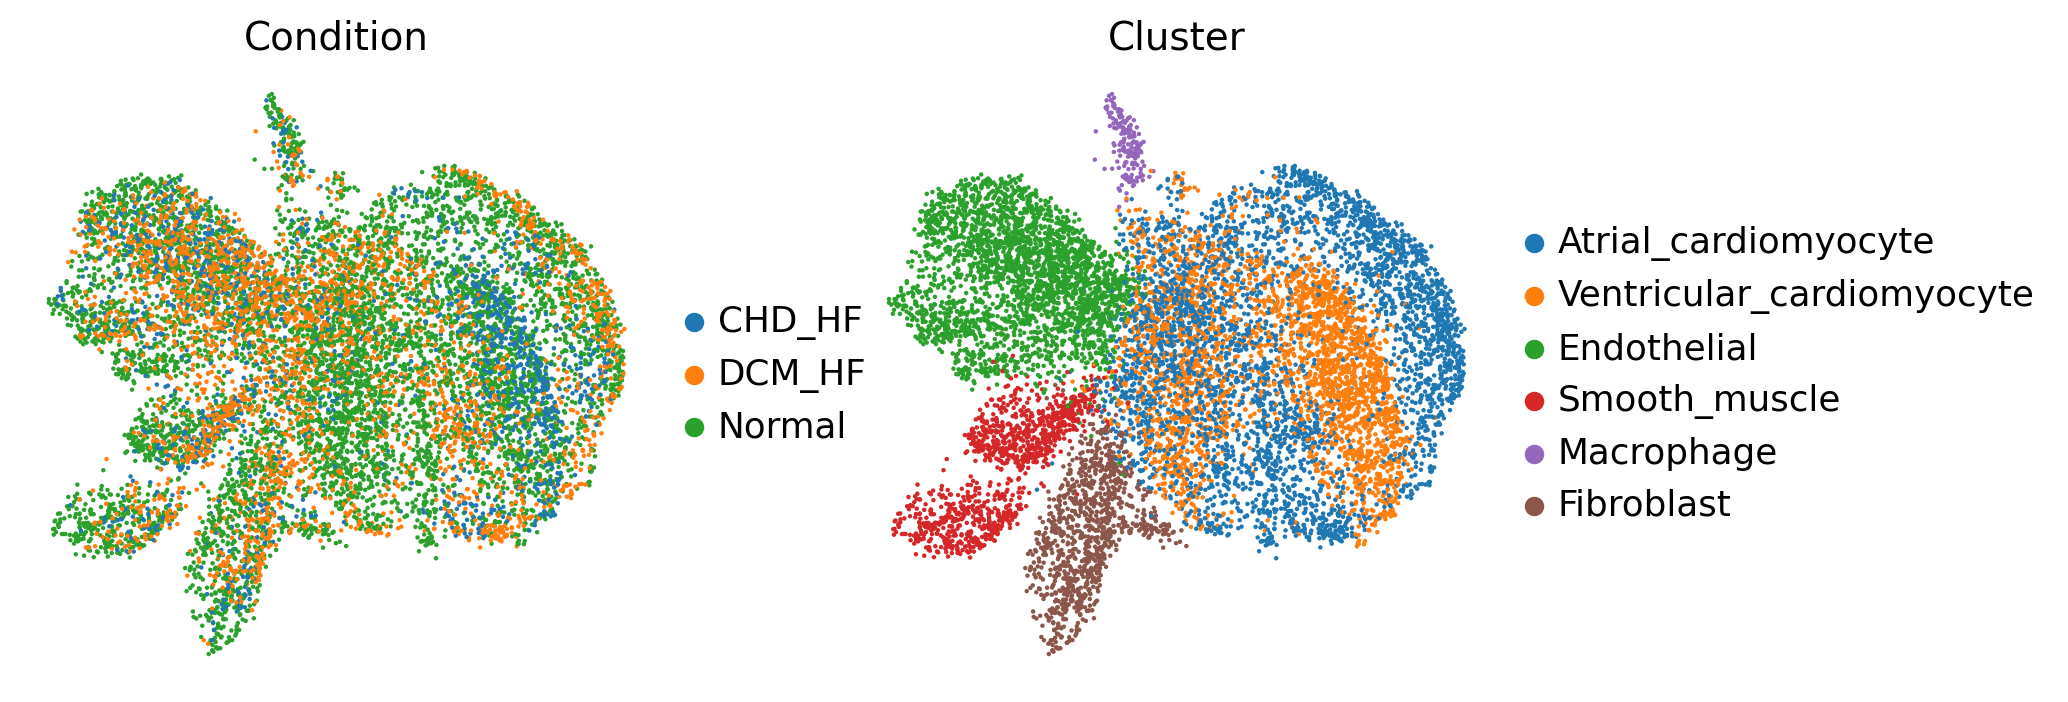

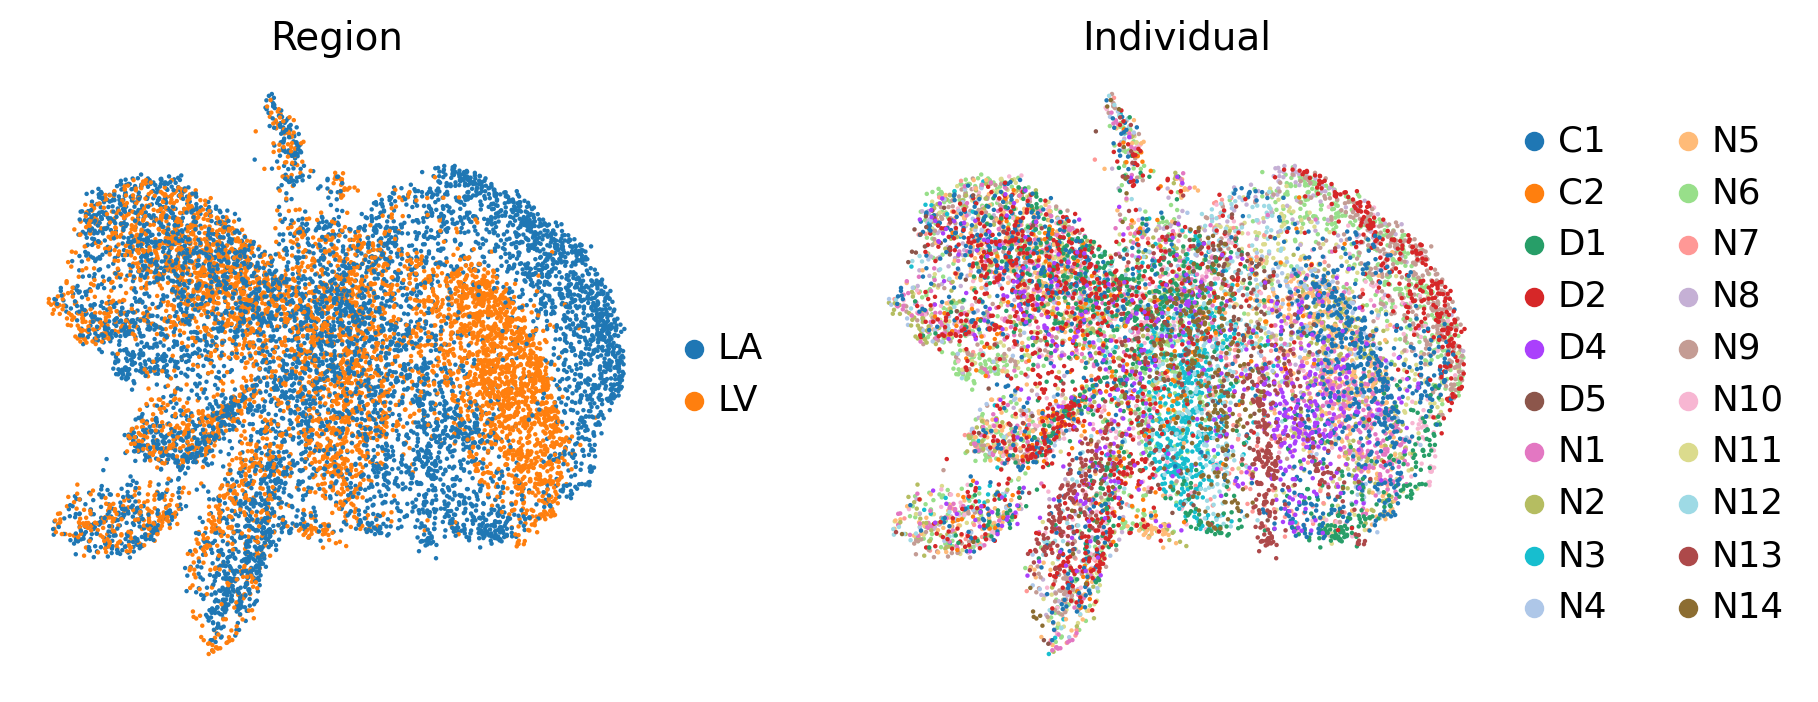

In [409]:
sc.pl.umap(anndl['GSE109816'], color=['Condition', 'Cluster'])
sc.pl.umap(anndl['GSE109816'], color=['Region', 'Individual'])

Trying to set attribute `.uns` of view, copying.


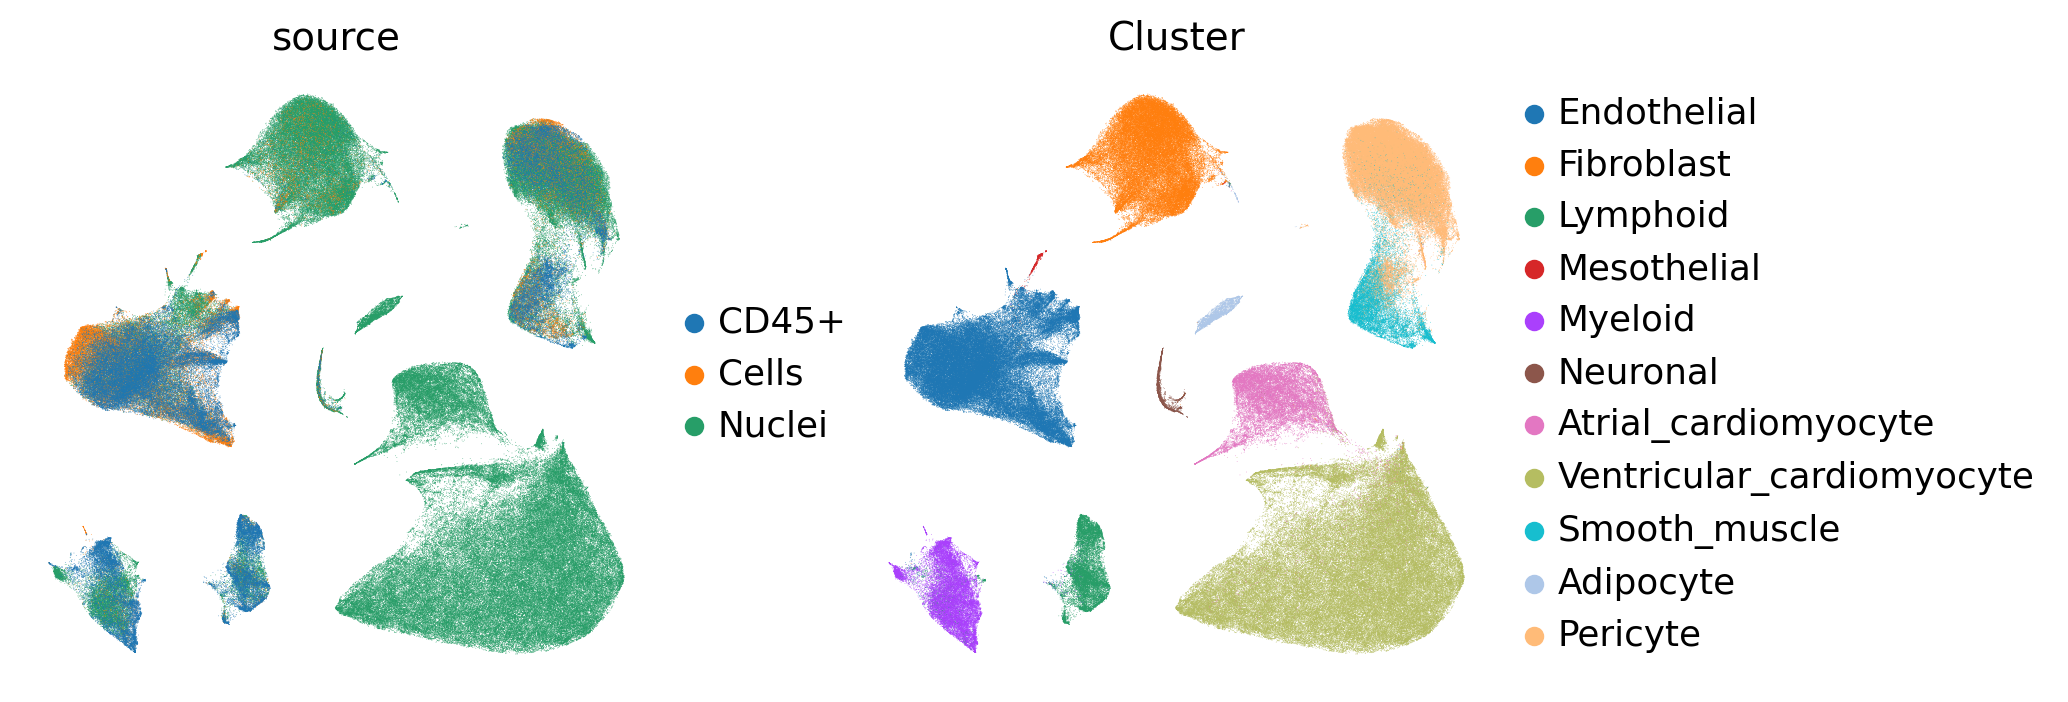

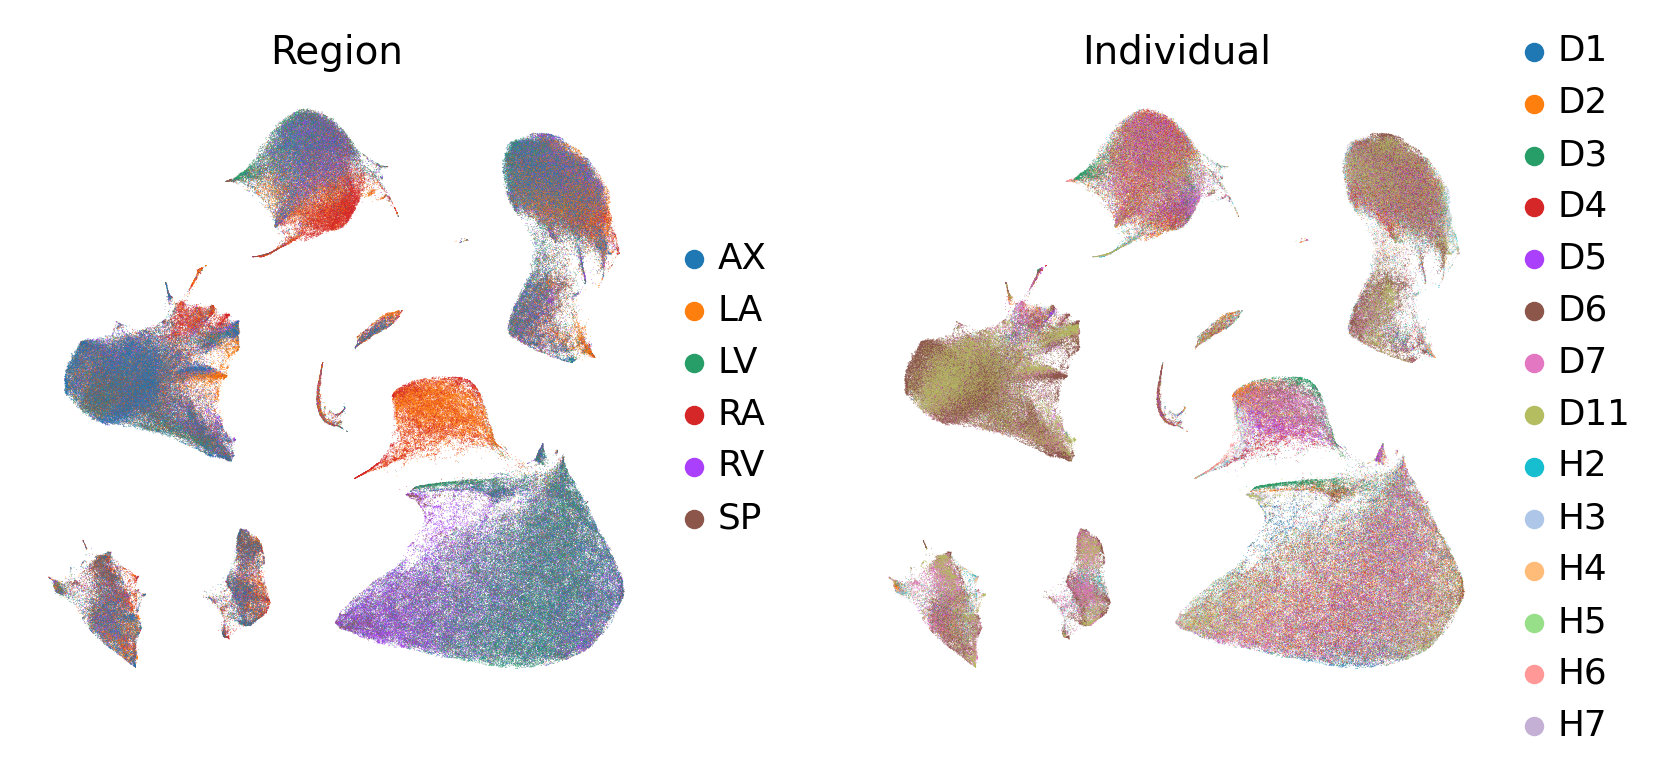

In [411]:
sc.pl.umap(anndl['HCA_Heart'], color=['source', 'Cluster'])
sc.pl.umap(anndl['HCA_Heart'], color=['Region', 'Individual'])

Trying to set attribute `.uns` of view, copying.


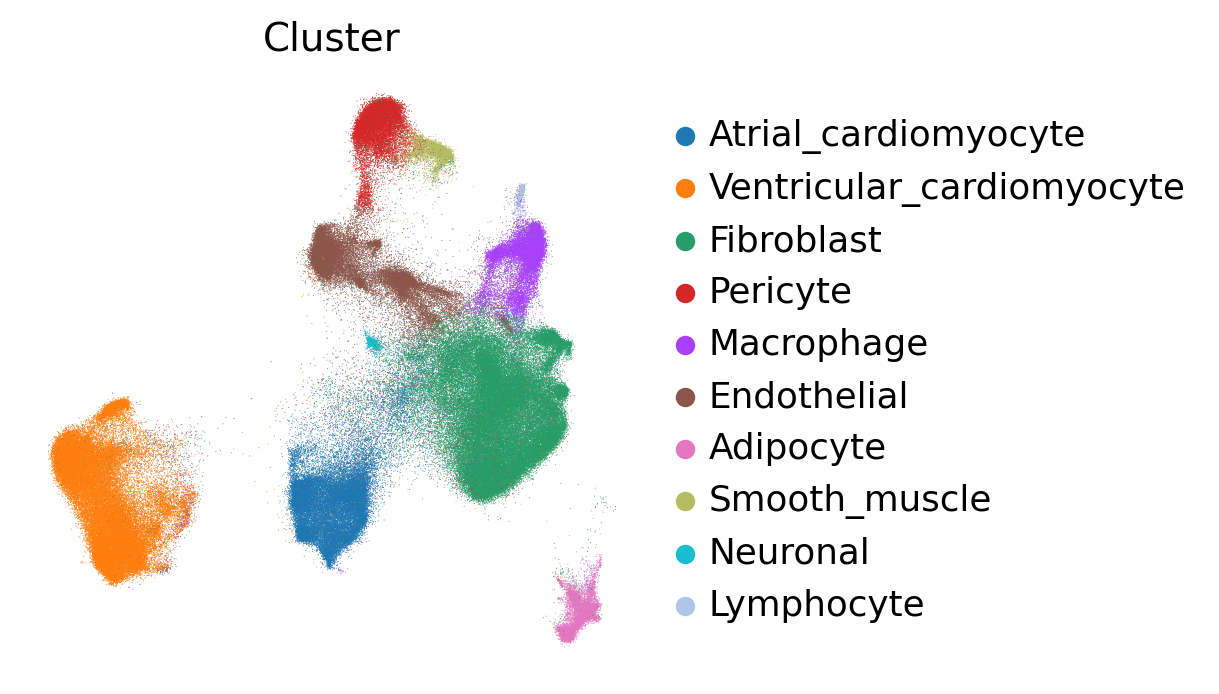

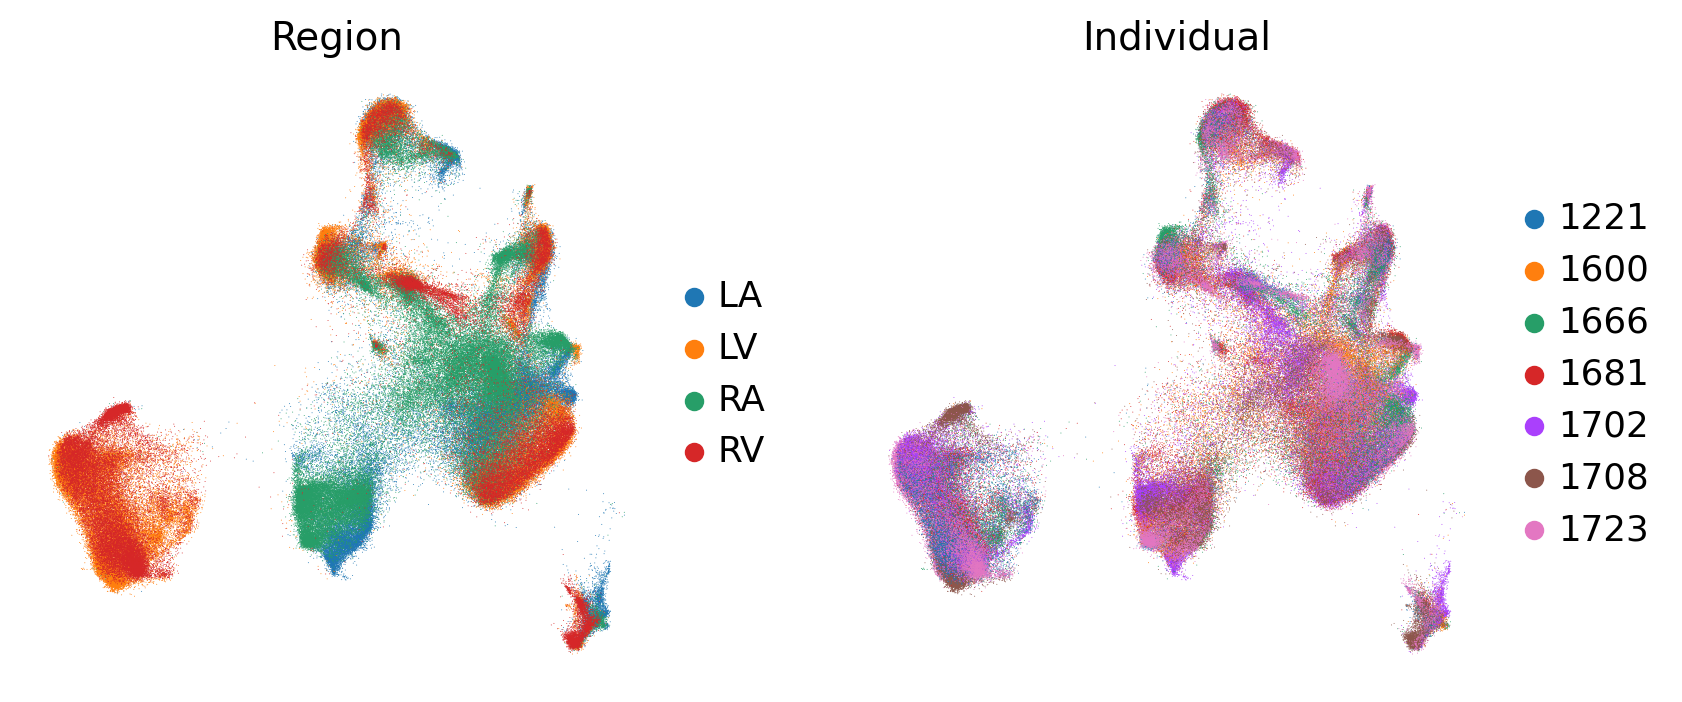

In [413]:
sc.pl.umap(anndl['SCP498'], color=['Cluster'])
sc.pl.umap(anndl['SCP498'], color=['Region', 'Individual'])


In [ ]:
# .scpy kernel

# adjustText==0.7.3
# anndata==0.7.5
# anndata2ri==1.0.6
# appdirs==1.4.4
# arboreto==0.1.6
# attrs==20.3.0
# backcall==0.2.0
# beautifulsoup4==4.9.3
# bioservices==1.7.11
# boltons==20.2.1
# cached-property==1.5.2
# certifi==2020.12.5
# cffi==1.14.4
# chardet==4.0.0
# click==7.1.2
# cloudpickle==1.6.0
# colorama==0.4.4
# colorlog==4.7.2
# cycler==0.10.0
# cytoolz==0.11.0
# dask==1.0.0
# decorator==4.4.2
# dill==0.3.3
# distributed==1.28.1
# easydev==0.11.0
# fa2==0.3.5
# frozendict==1.2
# get-version==2.1
# gevent==21.1.2
# greenlet==1.0.0
# grequests==0.6.0
# gseapy==0.10.2
# h5py==3.1.0
# HeapDict==1.0.1
# idna==2.10
# importlib-metadata==3.4.0
# interlap==0.2.7
# ipykernel==5.4.3
# ipython==7.16.1
# ipython-genutils==0.2.0
# jedi==0.18.0
# Jinja2==2.11.3
# joblib==1.0.0
# jupyter-client==6.1.11
# jupyter-core==4.7.0
# kiwisolver==1.3.1
# legacy-api-wrap==1.2
# leidenalg==0.8.3
# llvmlite==0.30.0
# locket==0.2.1
# loompy==3.0.6
# lxml==4.6.2
# MarkupSafe==1.1.1
# matplotlib==3.3.4
# msgpack==1.0.2
# MulticoreTSNE @ git+git://github.com/DmitryUlyanov/Multicore-TSNE@443731a47134d14653cfea526227a27cc3b38702
# multiprocessing-on-dill==3.5.0a4
# natsort==7.1.1
# networkx==2.5
# numba==0.46.0
# numexpr==2.7.2
# numpy==1.19.5
# numpy-groupies==0.9.13
# packaging==20.8
# pandas==1.1.5
# parso==0.8.1
# partd==1.1.0
# patsy==0.5.1
# pexpect==4.8.0
# pickleshare==0.7.5
# Pillow==8.1.0
# prompt-toolkit==3.0.14
# psutil==5.8.0
# ptyprocess==0.7.0
# pyarrow==0.16.0
# pycparser==2.20
# Pygments==2.7.4
# pyparsing==2.4.7
# pyscenic==0.10.4
# python-dateutil==2.8.1
# python-igraph==0.8.3
# pytz==2020.5
# PyYAML==5.4.1
# pyzmq==21.0.2
# requests==2.25.1
# requests-cache==0.5.2
# rpy2==3.4.2
# scanpy==1.6.1
# scikit-learn==0.24.1
# scipy==1.5.4
# seaborn==0.11.1
# setuptools-scm==5.0.1
# sinfo==0.3.1
# six==1.15.0
# sortedcontainers==2.3.0
# soupsieve==2.1
# statsmodels==0.12.1
# stdlib-list==0.8.0
# suds-jurko==0.6
# tables==3.6.1
# tblib==1.7.0
# texttable==1.6.3
# threadpoolctl==2.1.0
# toolz==0.11.1
# tornado==6.1
# tqdm==4.56.0
# traitlets==4.3.3
# typing-extensions==3.7.4.3
# tzlocal==2.1
# umap-learn==0.4.6
# urllib3==1.26.3
# wcwidth==0.2.5
# wrapt==1.12.1
# xlrd==2.0.1
# xmltodict==0.12.0
# zict==2.0.0
# zipp==3.4.0
# zope.event==4.5.0
# zope.interface==5.2.0